# Task 4

Generate the SWAP Test of the following states and apply a depolarization in a qubit gate error
from 0.01 to 0.50, you consider step size and evaluate, explain the limit, capabilities or
improvements that the computer has, make plots, number of gates, identify in your view what the limiting
factor is and how it can be improved if so.

$$
\left(\begin{array}{cc} 
\sqrt{0.3} \\
\sqrt{0.7}
\end{array}\right), 
\left(\begin{array}{cc} 
\sqrt{0.6} \\
\sqrt{0.4}
\end{array}\right)
$$ 

$$
\left(\begin{array}{cc} 
\sqrt{0.1} \\
\sqrt{0.2} \\
\sqrt{0.6} \\
\sqrt{0.1}
\end{array}\right), 
\left(\begin{array}{cc} 
\sqrt{0.} \\
\sqrt{0.5} \\
\sqrt{0.1} \\
\sqrt{0.4}
\end{array}\right)
$$ 

$$
\left(\begin{array}{cc} 
\sqrt{0.} \\
\sqrt{0.2} \\
\sqrt{0.2} \\
\sqrt{0.1} \\
\sqrt{0.2} \\
\sqrt{0.05} \\
\sqrt{0.05} \\
\sqrt{0.2}
\end{array}\right), 
\left(\begin{array}{cc} 
\sqrt{0.01} \\
\sqrt{0.10} \\
\sqrt{0.12} \\
\sqrt{0.13} \\
\sqrt{0.04} \\
\sqrt{0.} \\
\sqrt{0.35} \\
\sqrt{0.25} \\
\end{array}\right)
$$ 

The goal of the SWAP test is to get a measure of the similarity of two quantum states. This will be mathematically written as 
$$\langle \phi, \psi \rangle$$

In the swap test, we have use an auxiliary qubit and the probability of seeing 0 on the this qubit is 

$$P(0) = \frac{1}{2} + \frac{1}{2}|\langle \phi, \psi \rangle|^2 $$

This loosely means that higher the probability of zero, higher the similarity of the states. If we see an equal probability of 0 and 1, the states are orthogonal.

Source: https://en.wikipedia.org/wiki/Swap_test

First, let's do the swap test without any depolarizing error.

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit_aer.noise import depolarizing_error, NoiseModel
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

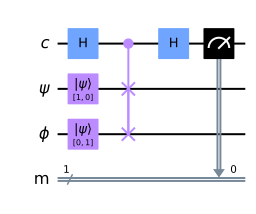

In [4]:
# swap test circuit
def swap_test_circuit(state_size, state_psi, state_phi):
    control_qubit, psi, phi = QuantumRegister(1, 'c'), QuantumRegister(state_size, '\psi'), QuantumRegister(state_size, '\phi')
    cl = ClassicalRegister(1, "m")
    swap_test_ckt = QuantumCircuit(control_qubit, psi, phi, cl)
    swap_test_ckt.initialize(state_psi, psi, normalize=True)
    swap_test_ckt.initialize(state_phi, phi, normalize=True) #maybe some how change the label of this?
    swap_test_ckt.h(0)
    for qubit in range(state_size):
        swap_test_ckt.cswap(control_qubit, psi[qubit], phi[qubit])
    swap_test_ckt.h(0)
    swap_test_ckt.measure(0, 0)
    return swap_test_ckt

swap_test_circuit(1, np.array([1,0]), np.array([0,1])).draw("mpl")

In [39]:
def perform_swap_test(state_size, Lambda=0, shots=100000, depol_channel_type="global"):
    # encoding the states mentioned above
    if state_size == 1:
        state_psi = np.array([np.sqrt(0.3), np.sqrt(0.7)])
        state_phi = np.array([np.sqrt(0.6), np.sqrt(0.4)])
    elif state_size == 2:
        state_psi = np.array([np.sqrt(0.1), np.sqrt(0.2), np.sqrt(0.6), np.sqrt(0.2)])
        state_phi = np.array([0, np.sqrt(0.5), np.sqrt(0.1), np.sqrt(0.4)])
    elif state_size == 3:
        state_psi = np.array([np.sqrt(0.01), np.sqrt(0.10), np.sqrt(0.12), np.sqrt(0.13), 
                            np.sqrt(0.04), 0, np.sqrt(0.35), np.sqrt(0.25)])
        state_phi = np.array([0, np.sqrt(0.2), np.sqrt(0.2), np.sqrt(0.1),
                            np.sqrt(0.2), np.sqrt(0.05), np.sqrt(0.05), np.sqrt(0.2)])

    # making the quantum circuit
    swap_test_ckt = swap_test_circuit(state_size=state_size, state_psi=state_psi, state_phi=state_phi)
    
    # adding depolarizing error
    noise_model = NoiseModel()
    noise = depolarizing_error(param=Lambda, num_qubits=1)
    if depol_channel_type=="global":
        noise_model.add_all_qubit_quantum_error(noise, ['u1', 'u2', 'u3'])
    elif depol_channel_type=="cswap":
        noise_model.add_all_qubit_quantum_error(noise, ['cswap'])
    simulator = AerSimulator(noise_model=noise_model)
    swap_test_ckt = transpile(swap_test_ckt, simulator, optimization_level=0)

    # Run and get counts
    result = simulator.run(swap_test_ckt, shots=shots).result()
    counts = result.get_counts(swap_test_ckt)
    # plot_histogram(counts)


    # if 1 is measured non zero number of times, the states are not perfectly identical"
    # print(counts)
    if '1' in counts:
        P_0 = counts['0']/(counts['0']+counts['1'])
        # it is possible that P_0 comes out less than 0.5 from the computation
        inner_product = np.sqrt(2*(np.abs(P_0 - 0.5)))
    else:
        inner_product = 1

    return inner_product, P_0

Inner Product = 0.9542221963463227


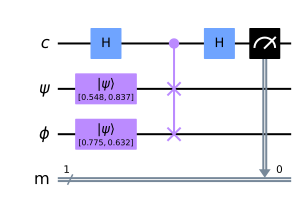

In [40]:
# Swap test on provied one qubits states
print("Inner Product =",  perform_swap_test(1, Lambda=0)[0])
swap_test_circuit(1, np.array([np.sqrt(0.3),np.sqrt(0.7)]), np.array([np.sqrt(0.6),np.sqrt(0.4)])).draw("mpl")

Inner Product = 0.8042139018942659


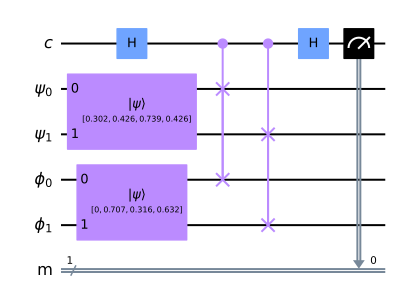

In [41]:
# Swap test on provied one qubits states
print("Inner Product =",  perform_swap_test(2, Lambda=0)[0])
swap_test_circuit(2, np.array([np.sqrt(0.1), np.sqrt(0.2), np.sqrt(0.6), np.sqrt(0.2)]), 
                    np.array([0, np.sqrt(0.5), np.sqrt(0.1), np.sqrt(0.4)])).draw("mpl")

Inner Product = 0.8562826636105626


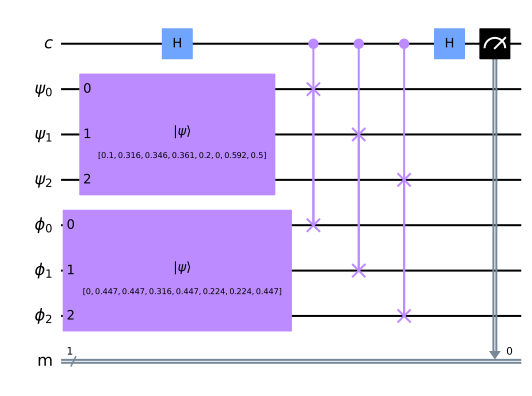

In [42]:
# Swap test on provied one qubits states
print("Inner Product =",  perform_swap_test(3, Lambda=0)[0])
swap_test_circuit(3, np.array([np.sqrt(0.01), np.sqrt(0.10), np.sqrt(0.12), np.sqrt(0.13), 
                            np.sqrt(0.04), 0, np.sqrt(0.35), np.sqrt(0.25)]), 
                    np.array([0, np.sqrt(0.2), np.sqrt(0.2), np.sqrt(0.1),
                            np.sqrt(0.2), np.sqrt(0.05), np.sqrt(0.05), np.sqrt(0.2)])).draw("mpl")

The problem statement does not clearly state what to add the depolarizing noise to (only some gates, only some qubtis or globally).
### So, let's add a global depolarizing noise model

In [43]:
# The response to noise each qubits state
noisy_tests_1q, noisy_tests_2q, noisy_tests_3q = [], [], []
lambda_min = 0
lambda_max = 0.5
Lambdas = np.linspace(lambda_min, lambda_max, 100)
for i in Lambdas:
    noisy_tests_1q.append(perform_swap_test(1, Lambda=i))
    noisy_tests_2q.append(perform_swap_test(2, Lambda=i, shots=100000))
    noisy_tests_3q.append(perform_swap_test(3, Lambda=i, shots=100000))

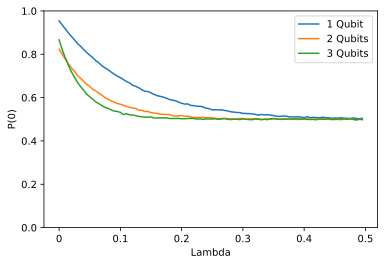

In [44]:
plt.plot(list(map(lambda x: x[1], noisy_tests_1q)), label="1 Qubit")
plt.plot(list(map(lambda x: x[1], noisy_tests_2q)), label="2 Qubits")
plt.plot(list(map(lambda x: x[1], noisy_tests_3q)), label="3 Qubits")
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("P(0)")
plt.ylim(0,1)
plt.xticks([0, 20, 40, 60, 80, 100], [0, 0.1, 0.2, 0.3, 0.4 , 0.5])
plt.show()

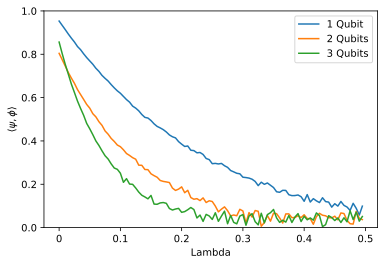

In [45]:
# variation of inner product of the two states with the depolarizing error parameter
# it must be noted in the graph that as lambda increases, equation (1) becomes less correct for calculating the inner product
# this is why the graph below approaches 0 as lambda increases instead of 1/2

plt.plot(list(map(lambda x: x[0], noisy_tests_1q)), label="1 Qubit")
plt.plot(list(map(lambda x: x[0], noisy_tests_2q)), label="2 Qubits")
plt.plot(list(map(lambda x: x[0], noisy_tests_3q)), label="3 Qubits")
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("$\langle \psi, \phi \\rangle $")
plt.ylim(0,1)
plt.xticks([0, 20, 40, 60, 80, 100], [0, 0.1, 0.2, 0.3, 0.4 , 0.5])
plt.show()

The effect of depolariztion is much more adverse on 2 qubits and 3 qubit states. This is because these states have way more degrees of freedom to depolarize to compared to a 1 qubits state. For 2 qubits, $\ket{00}$ will depolarize to $\ket{00} + \ket{01} + \ket{10} + \ket{11}$ (4 degrees of freedom), as compared to only 2 for 1 qubits state. Similarly, 3 qubits states have 8 degrees of freedom.

## Using Zero Error Extrapolation to Mitigate this Error

It is clear from the graph above that the simply using polynomial extrapolation might give good results in estmating the swap test results, atleast for lower values of depolarization error. 

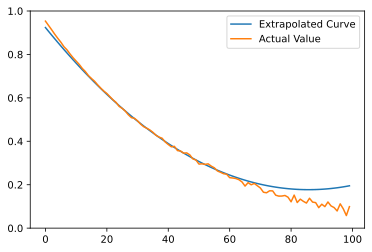

In [46]:
# let's take the P(0) values in the 0.1-0.3 range and estimate the inner product value at 0 error
noisy_tests_1q = np.array(noisy_tests_1q)
coeffs = np.polyfit(x=Lambdas[20:60], y=noisy_tests_1q[20:60, 0], deg=2)
plt.plot(np.polyval(coeffs, Lambdas), label="Extrapolated Curve")
plt.plot(noisy_tests_1q[:, 0], label="Actual Value")
plt.ylim(0,1)
plt.legend()

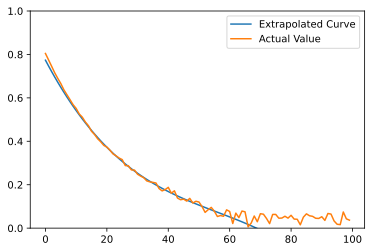

In [47]:
# let's take the P(0) values in the 0.1-0.3 range and estimate the inner product value at 0 error
noisy_tests_2q = np.array(noisy_tests_2q)
coeffs = np.polyfit(x=Lambdas[20:60], y=noisy_tests_2q[20:60, 0], deg=3)
plt.plot(np.polyval(coeffs, Lambdas), label="Extrapolated Curve")
plt.plot(noisy_tests_2q[:, 0], label="Actual Value")
plt.ylim(0,1)
plt.legend()

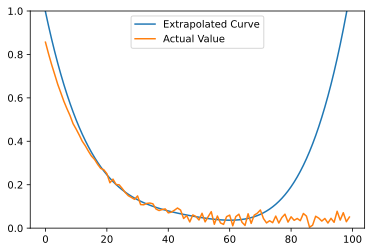

In [48]:
# let's take the P(0) values in the 0.1-0.3 range and estimate the inner product value at 0 error
noisy_tests_3q = np.array(noisy_tests_3q)
coeffs = np.polyfit(x=Lambdas[20:60], y=noisy_tests_3q[20:60, 0], deg=4)
plt.plot(np.polyval(coeffs, Lambdas), label="Extrapolated Curve")
plt.plot(noisy_tests_3q[:, 0], label="Actual Value")
plt.ylim(0,1)
plt.legend()

It can be seen that the error in the SWAP test of n qubits due to depolarizing noise can be well mitigated by polynomial extrapolation of N+1 degrees.

## Intuitive Relation between CSWAP Gate and Depolarization Error

I would like to emphasize that this section does not contain a rigorous mathematical treatment of the argument presented. 

Regular CSWAP Gate - 

$$\ket{0, \psi, \phi} \rightarrow \ket{0, \psi, \phi}$$
$$\ket{1, \psi, \phi} \rightarrow \ket{1, \phi, \psi}$$

Following is the equation associated with a depolarizing channel - 
$$\ket{\rho} = (1-\lambda)U\ket{0}^{\bigotimes n} + \lambda \frac{I}{2^n}$$ 

As shown in Neilson and Chuang, we can visualize this depolarizing channel with the following circuit - 

<p align="center">
<img src="depolarizing_error_vis.jpeg" style="height: 100px; width:200px;">
</p>

Therefore, if we imagine an imperfect CSWAP gate that does the following - 

$$\ket{0, \psi, \phi} \rightarrow \ket{0, \psi + \lambda_0\phi, \phi + \lambda_0\psi}$$
$$\ket{1, \psi, \phi} \rightarrow \ket{1, \phi + \lambda_1\psi, \psi + + \lambda_1\phi}$$

It swaps to a small extent ($\lambda_0$) even when it's not supposed to and doesn't perfectly swap (leaves a small portion $\lambda_1$) when it's supposed to.

We can see that it somewhat mimics the depolarizing noise channel. An imperfect CSWAP gate will act as a depolarizing noise channel.